In [1]:
#!/usr/bin/python3
import sys, os, re
import random

#local importing
#sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

from collections import defaultdict, OrderedDict, Counter
import itertools

import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pickle


In [4]:
def load_f(fname):
    with open(fname, 'rb') as inp:
        return pickle.load(inp)
    
dist_main = load_f('distances_new_tm_15oct23_allmodels.pkl')
scores = pd.read_csv('eval_scores_LREC24_updated.csv')

In [8]:
filtered = pd.DataFrame(scores.loc[(scores.s_language == scores.t_language)&
                                   (scores.s_corpus == scores.t_corpus)]
                        .groupby(["s_language", "s_corpus", "s_domain", "s_sample", "seed", "t_language", "t_corpus"])['LAS'].apply(list)
                        .reset_index())

In [10]:
filtered.columns

Index(['s_language', 's_corpus', 's_domain', 's_sample', 'seed', 't_language',
       't_corpus', 'LAS'],
      dtype='object')

## data for correlation and plots: 
- rel_LAS, rel_HD, abs_LAS, abs_HD

In [37]:
plot_data_REL = []
plot_data_ABS = []

def reorder_scores(df, dist):
    
    language = df['s_language']
    source_domain = df['s_domain']
    source_sample = df['s_sample']
    source_seed = df['seed']
    LAS_list = df['LAS']
    corpus = df['s_corpus']
    
    # get list of target domains for a given source domain within the considered treebank
    domains = scores.loc[(scores.s_language == language)&(scores.s_corpus == corpus)&
                         (scores.s_domain == source_domain)&(scores.s_sample == source_sample)&(scores.seed == source_seed)&
                         (scores.t_language == language)&(scores.t_corpus == corpus), 't_domain'].tolist()
    
    # get list of relative distances, relative to matching genre pair
    rel_LAS_list = [LAS_list[domains.index(source_domain)] - x for x in LAS_list]
    # get list of absolute distances
    abs_LAS_list = LAS_list
    
    assert len(rel_LAS_list) == len(abs_LAS_list)
    
    s = re.match(r's(\d)',source_sample).group(1) #training sample number
    rs = re.match(r'rs(\d+)',source_seed).group(1) #training seed number  
    
    # get distances for matching genre pair
    for key in dist_main[f'{language}__{corpus}'].keys():
        if re.match(r'^'+source_domain+'_'+s+'_'+rs+'---.*$', key):
            if re.match(r'^([a-zA-Z-_]+_\d_\d+)---([a-zA-Z-_]+)$', key).group(2) == source_domain:
                
                matching_genre_dist = dist_main[f'{language}__{corpus}'][key]['distances'][dist]
                break
        
    # get relative distances
    for target_domain, rel_las, abs_las in zip(domains, rel_LAS_list, abs_LAS_list):        
        for key in dist_main[f'{language}__{corpus}'].keys():           
            if re.match(r'^'+source_domain+'_'+s+'_'+rs+'---'+target_domain+'$', key):
                
                # absolute distance
                abs_dist = dist_main[f'{language}__{corpus}'][key]['distances'][dist]
                
                # calculate relative distance
                rel_dist = abs_dist - matching_genre_dist
                
                plot_data_REL.append((language, corpus, source_domain, s, rs, target_domain, rel_las, rel_dist))
                plot_data_ABS.append((language, corpus, source_domain, s, rs, target_domain, abs_las, abs_dist))
            else:
                continue
                
            break

# dist = 'kl'
# dist = 'jcrd'
dist = 'hlngr'       

filtered.apply(lambda df: reorder_scores(df, dist), axis = 1)


0      None
1      None
2      None
3      None
4      None
       ... 
253    None
254    None
255    None
256    None
257    None
Length: 258, dtype: object

## generate heatmaps: LAS and HD within each treebank

In [13]:
abs_df = pd.DataFrame(plot_data_ABS, columns = ['lang', 's_corpus', 's_domain', 'samp', 'seed', 't_domain', 'LAS', 'hlngr'])

def subst(x):
    if x == 'nonfiction_prose':
        x = 'nf_prose'
    else:
        pass
    return x 
    
abs_df['s_domain'] = abs_df.s_domain.apply(lambda x: subst(x))
abs_df['t_domain'] = abs_df.t_domain.apply(lambda x: subst(x))

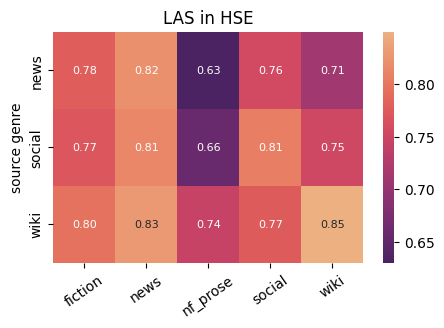

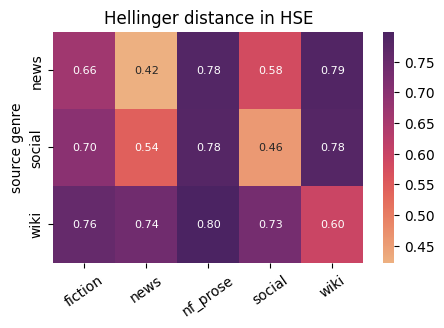

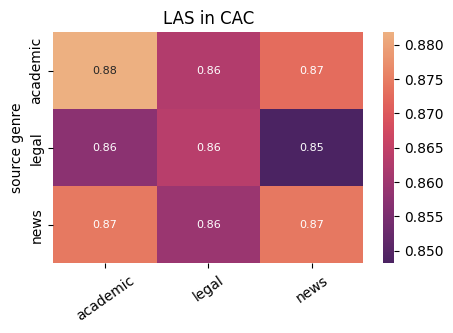

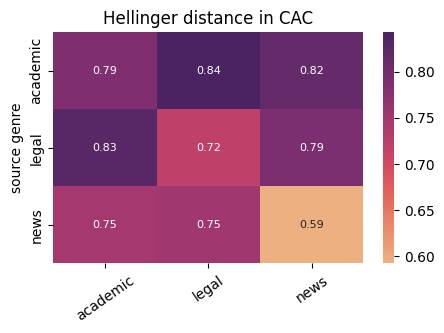

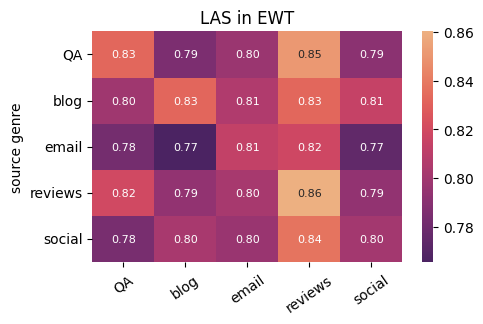

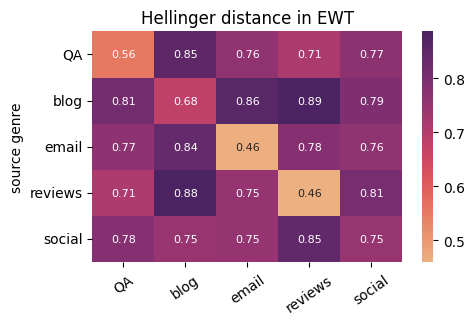

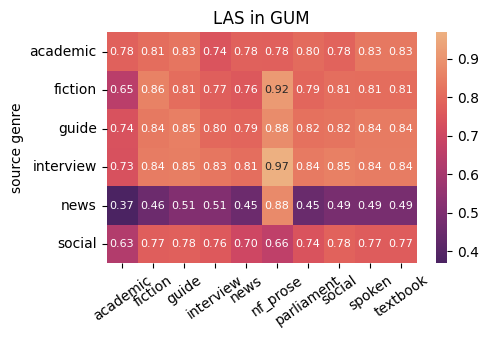

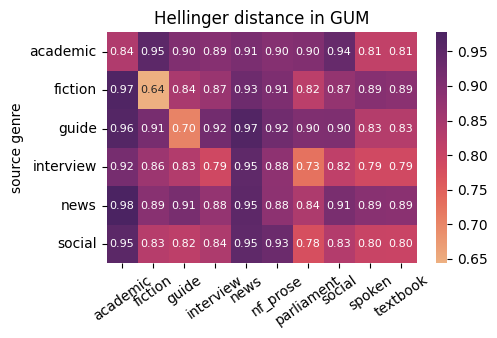

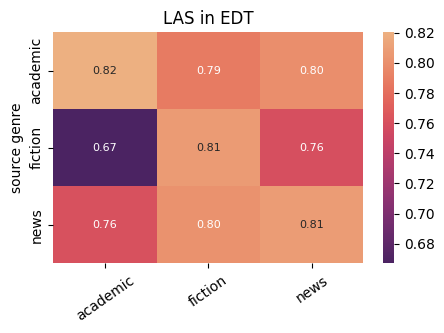

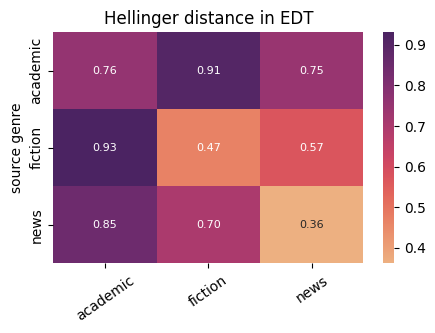

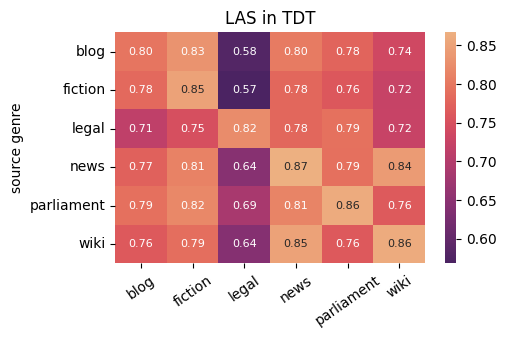

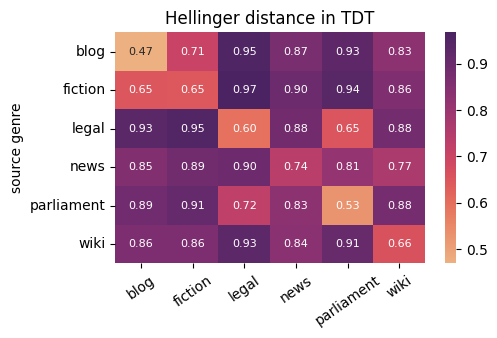

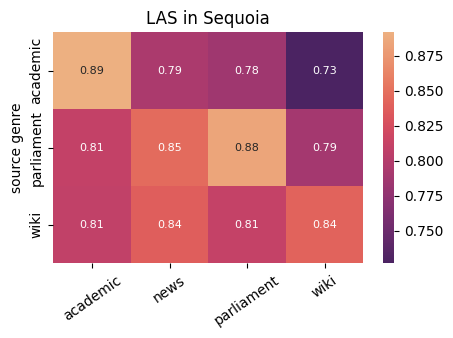

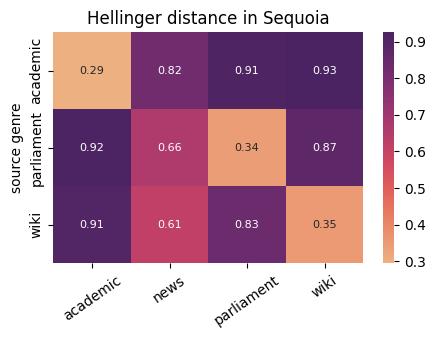

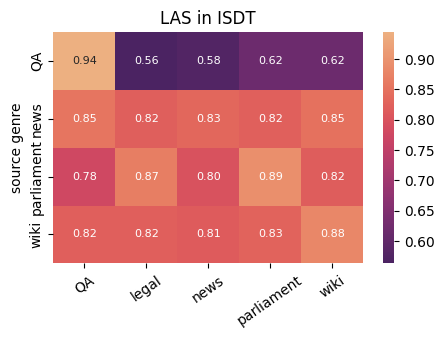

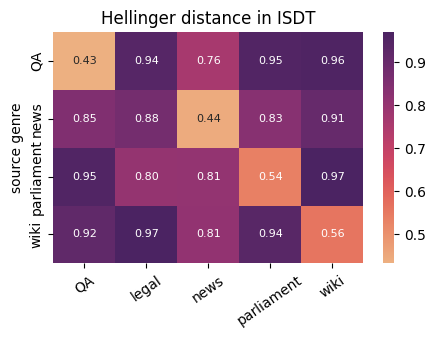

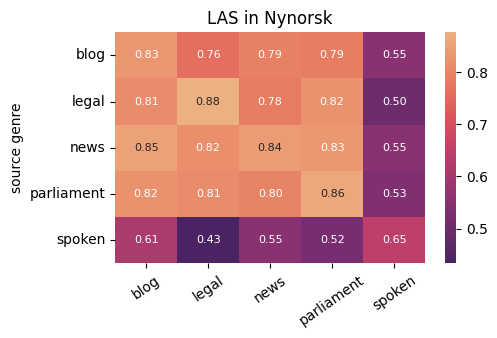

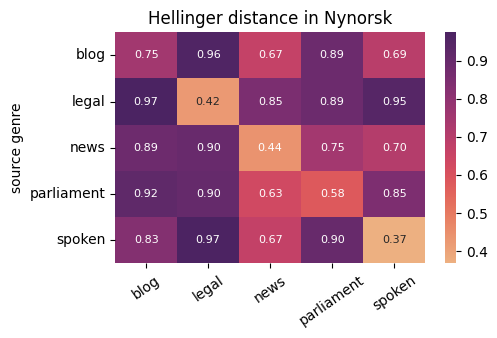

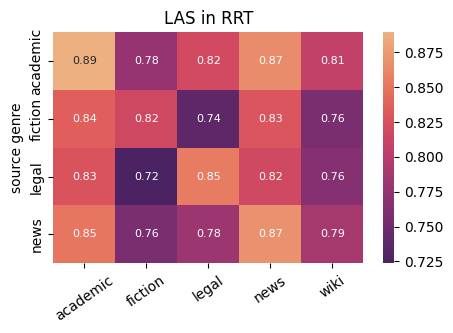

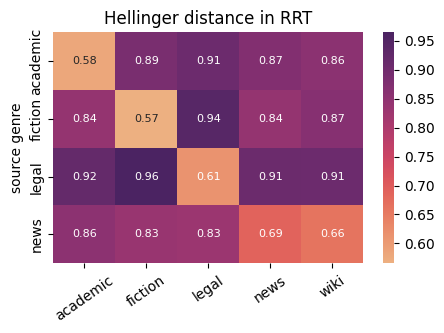

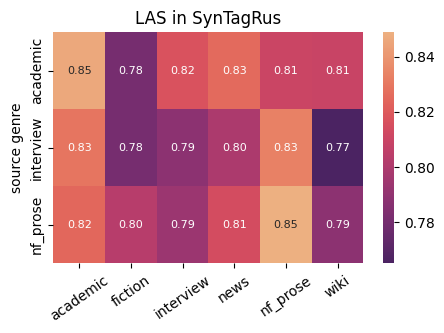

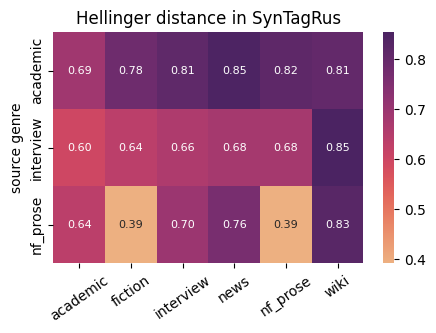

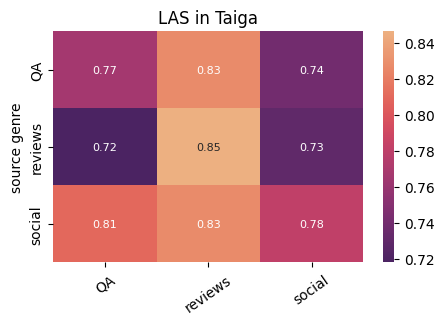

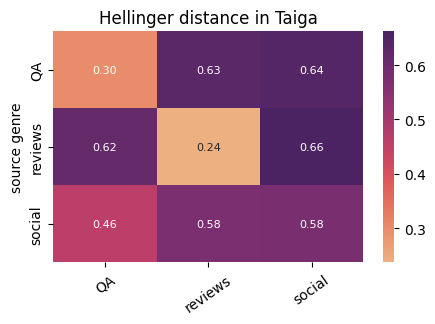

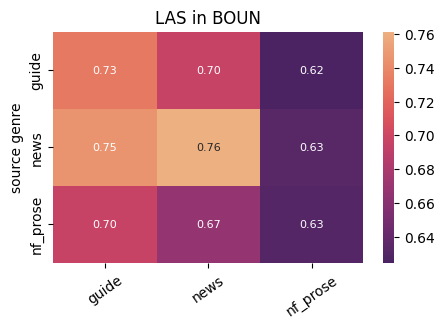

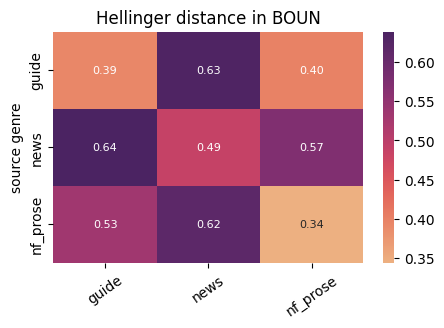

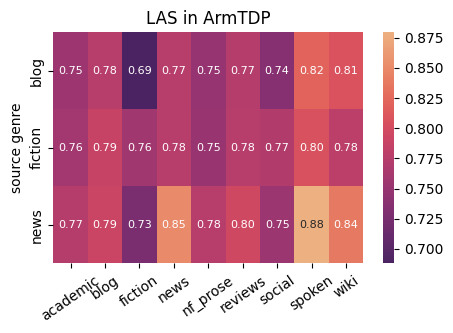

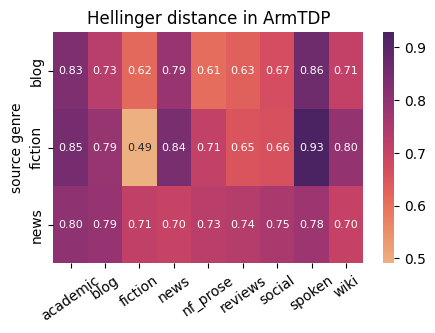

In [14]:
abs_df
abs_df_las = abs_df.groupby(["lang", "s_corpus", "s_domain", "t_domain"])['LAS'].mean().reset_index()
abs_df_hlngr = abs_df.groupby(["lang", "s_corpus", "s_domain", "t_domain"])['hlngr'].mean().reset_index()

for n, s_corpus in enumerate(abs_df.s_corpus.unique()):
    
    plt.figure(figsize=(5, 3))
    sub_grouped_abs_df = abs_df_las.loc[abs_df_las.s_corpus == s_corpus]    
    sub_grouped_LAS_pivoted = sub_grouped_abs_df.pivot(index=['s_domain'], columns=['t_domain'], values='LAS')
    sns.heatmap(sub_grouped_LAS_pivoted, annot=True, cmap="flare_r", fmt = ".2f", annot_kws={'size': 8})
    plt.xlabel('')    
    plt.ylabel('source genre')
    plt.xticks(rotation=35) 
    plt.title(f'LAS in {s_corpus}')
    # plt.savefig(f'LAS_{s_corpus}.png',dpi=300, bbox_inches = "tight")
    plt.show()
    
    plt.figure(figsize=(5, 3))
    sub_grouped_abs_df = abs_df_hlngr.loc[abs_df_hlngr.s_corpus == s_corpus]    
    sub_grouped_LAS_pivoted = sub_grouped_abs_df.pivot(index=['s_domain'], columns=['t_domain'], values='hlngr')
    sns.heatmap(sub_grouped_LAS_pivoted, annot=True, cmap="flare", fmt = ".2f", annot_kws={'size': 8})
    plt.xlabel('')    
    plt.ylabel('source genre')
    plt.xticks(rotation=35) 
    plt.title(f'Hellinger distance in {s_corpus}')
    # plt.savefig(f'HLNGR_{s_corpus}.png',dpi=300, bbox_inches = "tight")
    plt.show()

## correlation (in all genre pairs within the corresponding treebanks)
- based on rel_LAS and rel_HD

In [46]:
regplot_df = pd.DataFrame(plot_data_REL)
regplot_df.columns = ['lang', 'tbank', 'source_genre', 'sample', 'seed', 'target_genre', 'rel_LAS', 'rel_hlngr']
regplot_df = regplot_df[regplot_df.source_genre != regplot_df.target_genre]
len(regplot_df)

1035

In [39]:
# correlation without filters
stats.spearmanr(regplot_df.rel_hlngr, regplot_df.rel_LAS)

SignificanceResult(statistic=0.32519787970451136, pvalue=6.408954948887978e-27)

In [40]:
# correlation including filters
filt_tbs = ['ArmTDP', 'BOUN']
regplot_df_filt = regplot_df.query("tbank not in @filt_tbs")
stats.spearmanr(regplot_df_filt.rel_hlngr, regplot_df_filt.rel_LAS)

SignificanceResult(statistic=0.4186515633473369, pvalue=1.0348431194885943e-39)

## relationship in all treebanks (mean_rel_LAS and mean_rel_HD)

In [41]:
#exclude filter treebanks
filt_tbs = []
# filt_tbs = ['ArmTDP', 'BOUN']
regplot_df_filt = pd.DataFrame()
regplot_df_filt = regplot_df.query("tbank not in @filt_tbs")

result=pd.DataFrame() 
result = regplot_df_filt.groupby(['lang', 'tbank', 'source_genre', 'target_genre', 'sample'])[['rel_LAS', 'rel_hlngr']].agg('mean')
result = result.rename(columns={'rel_LAS': 'mean_rel_LAS', 'rel_hlngr': 'mean_rel_hlngr'}).reset_index()

mean_rel_LAS
Q1 = 0.00634427368669821, Q3 = 0.07437617371292102, Median = 0.03595218026728854, Upper_whisker = 0.17642402375225524, Lower_whisker = -0.095703576352636


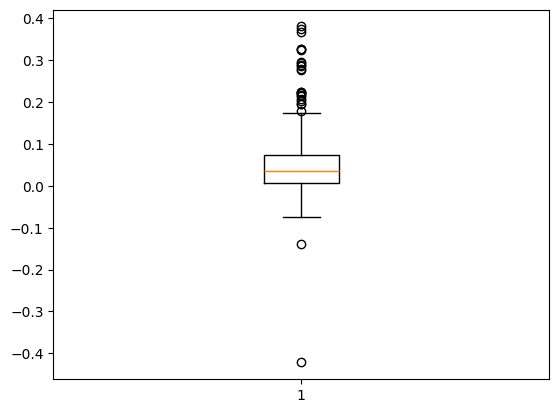

In [42]:
# explore the distribution of mean_rel_LAS
def calc_boxplot_stats(var):
    
    bp = plt.boxplot(var)
    # finding the 1st quartile
    q1 = np.quantile(var, 0.25) 
    # finding the 3rd quartile
    q3 = np.quantile(var, 0.75)
    med = np.median(var)
    # finding the iqr region
    iqr = q3-q1
    # finding upper and lower whiskers
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    print(f'Q1 = {q1}, Q3 = {q3}, Median = {med}, Upper_whisker = {upper_bound}, Lower_whisker = {lower_bound}')

print('mean_rel_LAS')
var = result.mean_rel_LAS.tolist()
calc_boxplot_stats(var)

In [43]:
len(result.query('(mean_rel_LAS <= 0.17)&(mean_rel_LAS >= -0.09)'))

400

In [48]:
# estimate distribution normality
res = stats.normaltest(result.query('(mean_rel_LAS <= 0.17)&(mean_rel_LAS >= -0.09)').mean_rel_LAS.tolist())
res.statistic, res.pvalue

(6.359791099903344, 0.04158999897171408)

In [31]:
result_selection = result.query('(mean_rel_LAS <= 0.17)&(mean_rel_LAS >= -0.09)')
stats.spearmanr(result_selection.mean_rel_hlngr, result_selection.mean_rel_LAS)

SignificanceResult(statistic=0.25749272506934595, pvalue=1.76951925926175e-07)

In [49]:
# when we filter ArmTDP and BOUN out:
# SignificanceResult(statistic=0.3904607916840014, pvalue=7.904170714811003e-14)

## scatter plot: all data
- white quadrants correspond to cases where 
rel_HD correlates with rel_LAS 
- pink quadrants show the deviation from the expected behaviour.
As we observe, this may be explained by (i) the difficulty of the target
or/and (ii) equal topical proximity between source and several targets

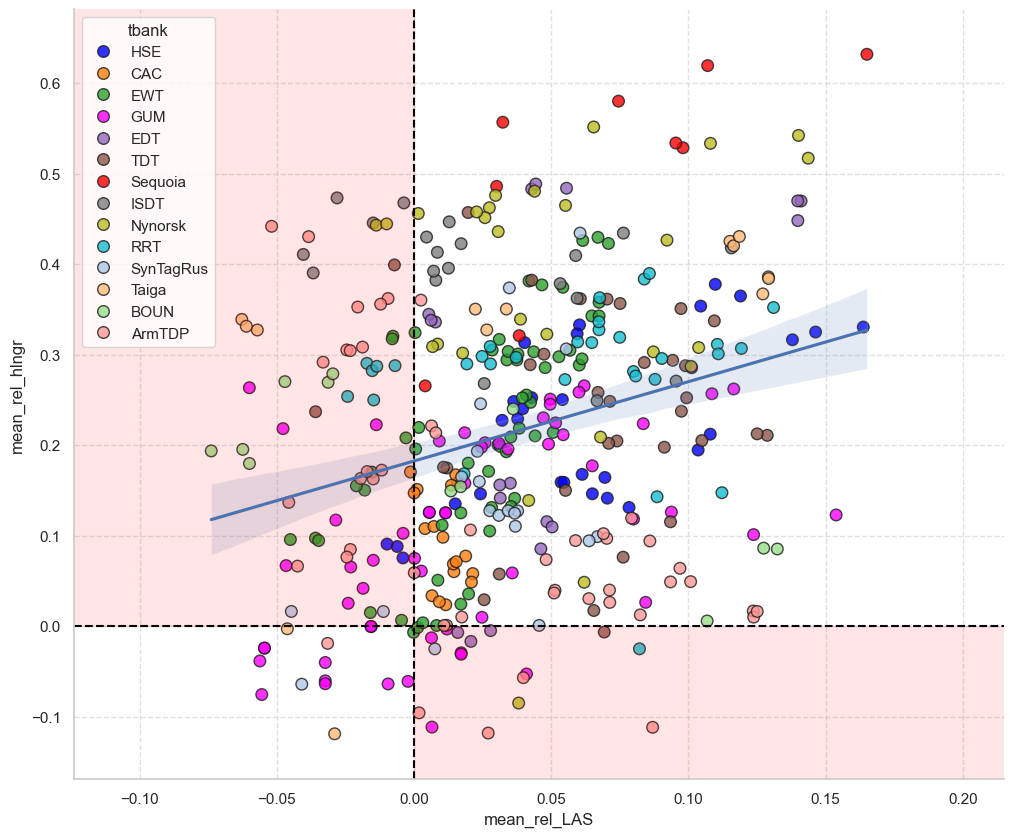

In [57]:
# plots all data points including outliers

custom_colors = ['blue', '#ff7f0e', '#2ca02c', 'magenta', '#9467bd', '#8c564b', 'red', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

def scatter_plot_rel_HD_rel_LAS(outliers=False, regplot=True):

    if outliers == True:
        regplot = False
        data = result
        
    else:
        result_selection = result.query('(mean_rel_LAS <= 0.17)&(mean_rel_LAS >= -0.09)')
        data = result_selection

    hue = 'tbank'
    dist = 'mean_rel_hlngr'
    plt.figure(figsize = (12,10))
    sns.set(style="whitegrid")
    g = sns.scatterplot(x='mean_rel_LAS', y=dist, data=data, palette=custom_colors,hue=hue, s=70, alpha=0.8, edgecolor="k", linewidth=1)
    if regplot == True:
        sns.regplot(x='mean_rel_LAS', y=dist, data=data, scatter=False, fit_reg = True)
    else:
        pass
    plt.axvline(0, c='black', ls='--') 
    plt.axhline(0, c='black', ls='--') 
    plt.fill_between((0,-7),(0,0), (7, 7), color = 'red', alpha = 0.1)
    plt.fill_between((0,7),(0,0), (-7, -7), color = 'red', alpha = 0.1)
    plt.ylim(data.mean_rel_hlngr.min()-0.05,data.mean_rel_hlngr.max()+0.05)
    plt.xlim(data.mean_rel_LAS.min()-0.05,data.mean_rel_LAS.max()+0.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    sns.despine()


    # plt.savefig(f'{dist}_rel_LAS-rel_HLNGR_plot_{hue}_mean_with_outliers.png',dpi=300, bbox_inches = "tight")
    plt.show()

scatter_plot_rel_HD_rel_LAS(outliers=False, regplot=True)

## scatter plots: genre pairs (relationship of rel_HD and rel_LAS)

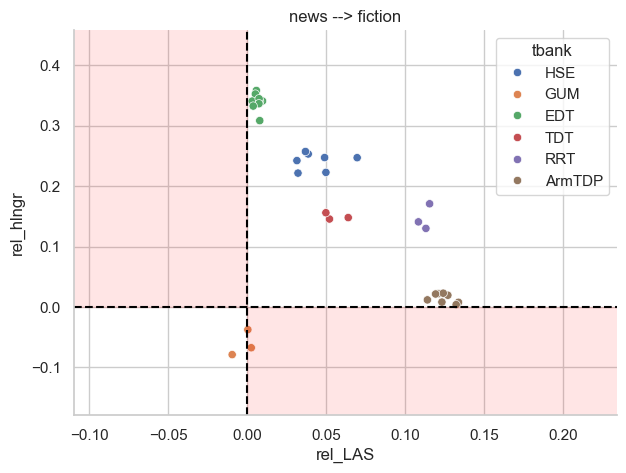

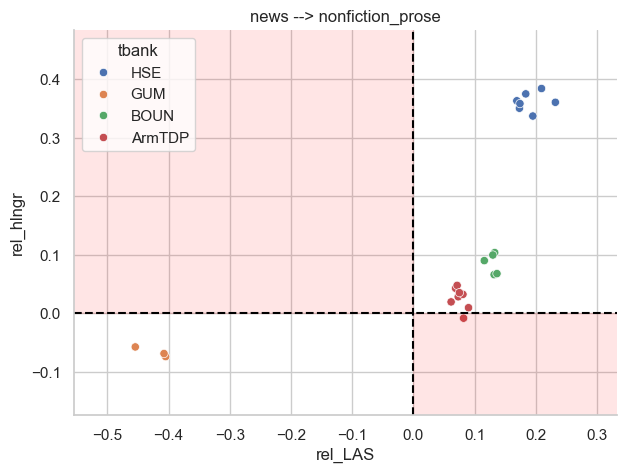

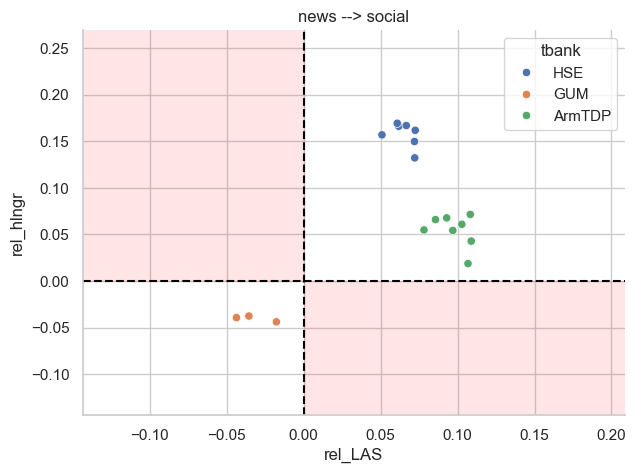

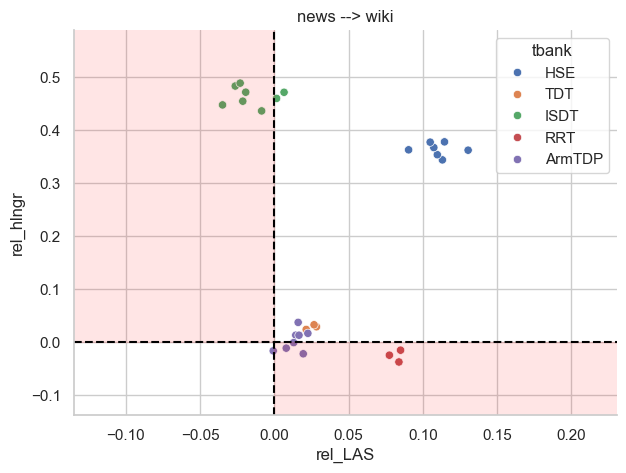

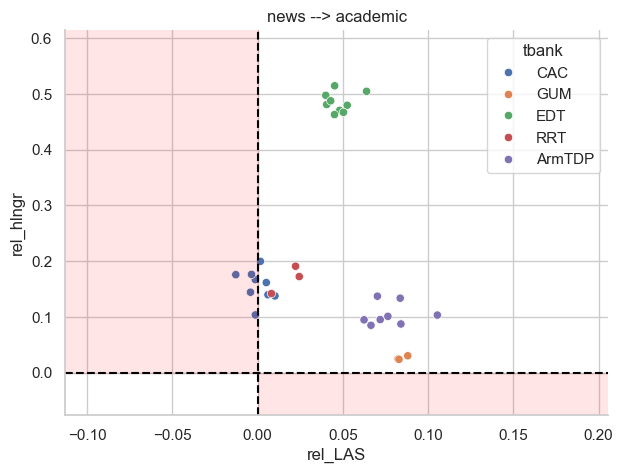

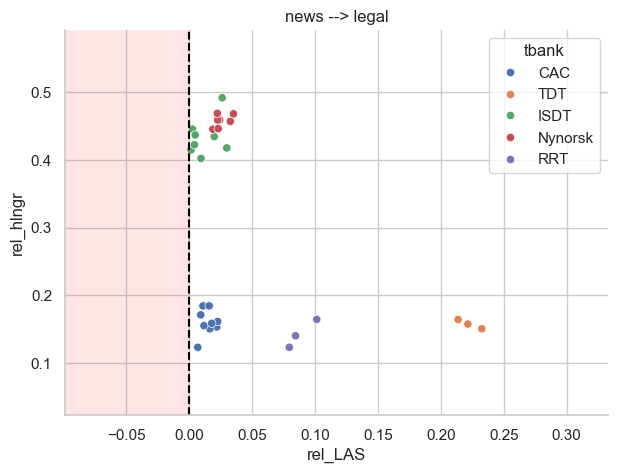

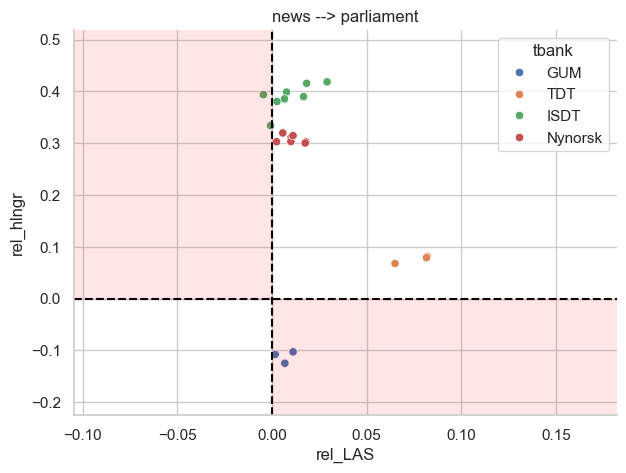

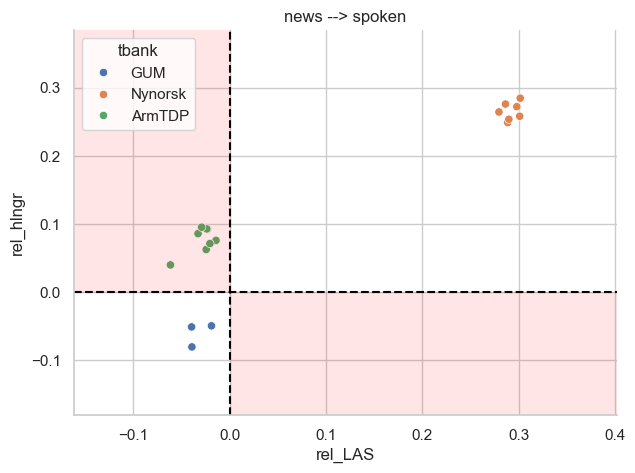

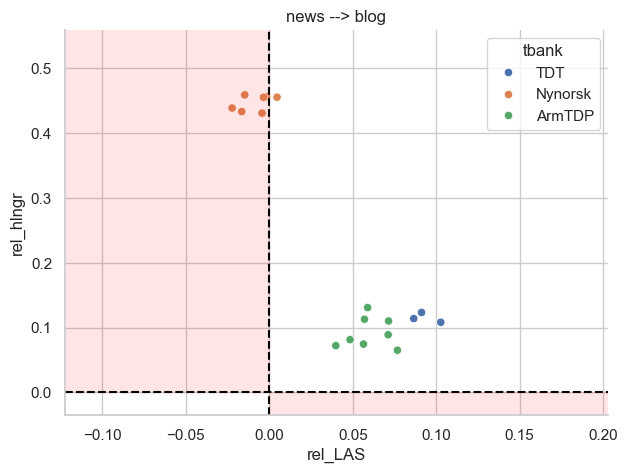

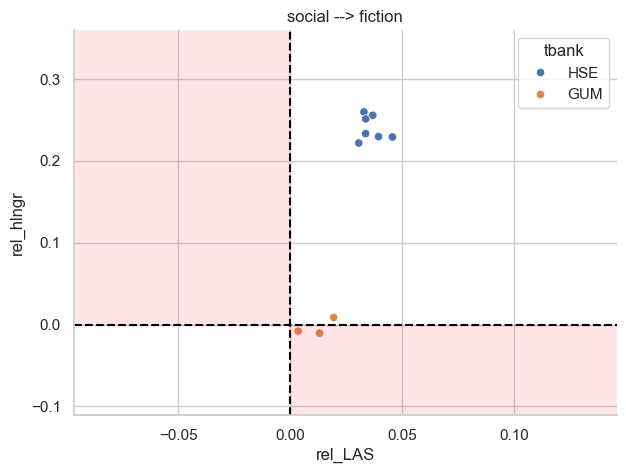

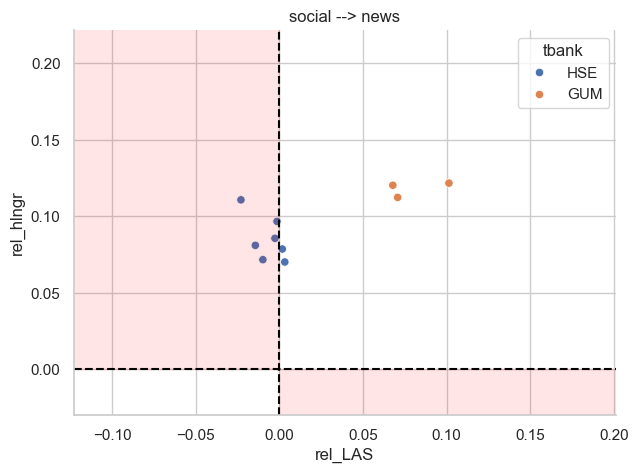

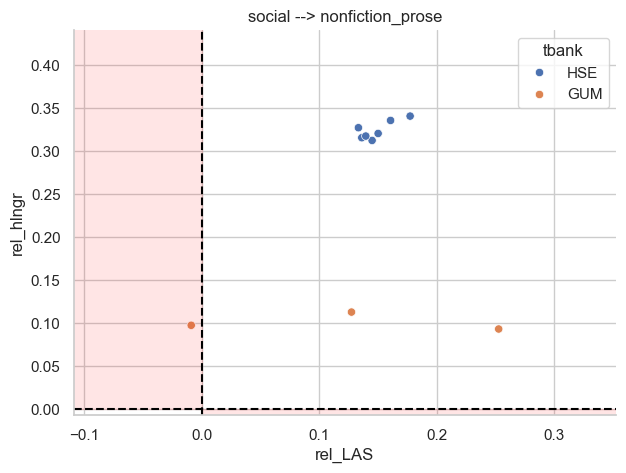

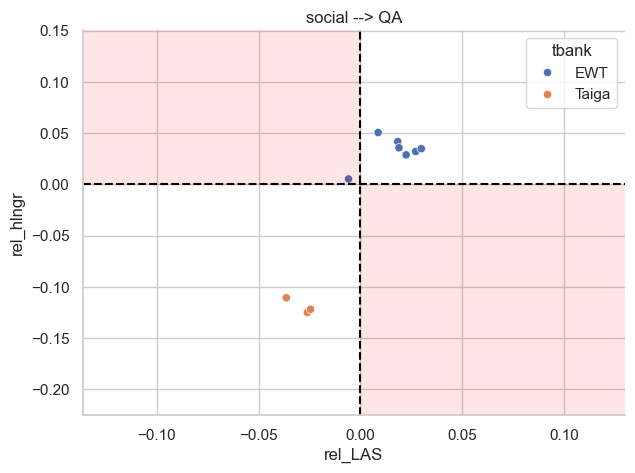

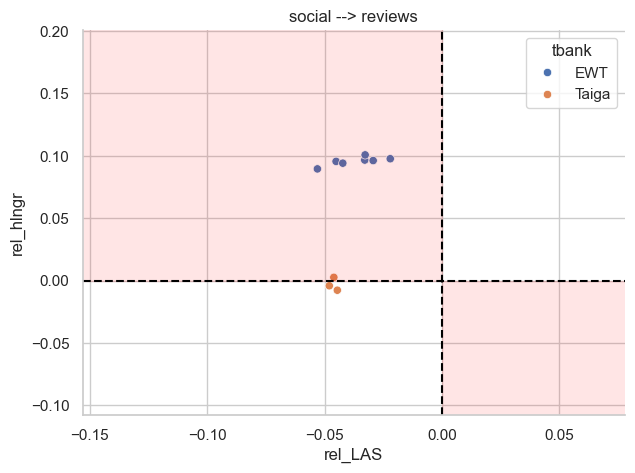

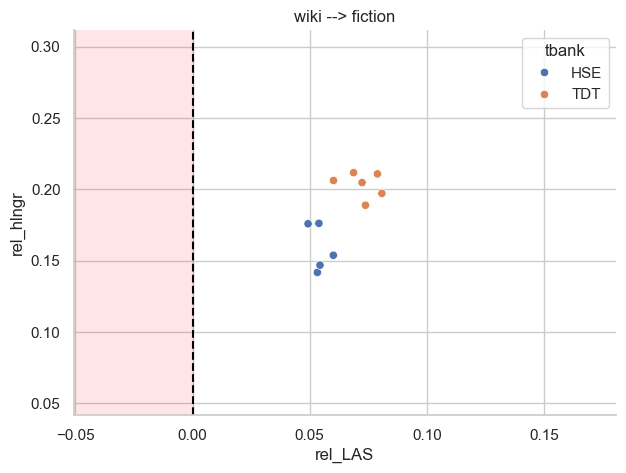

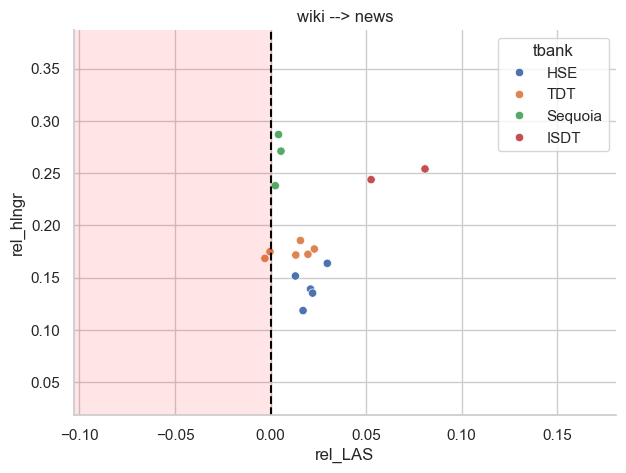

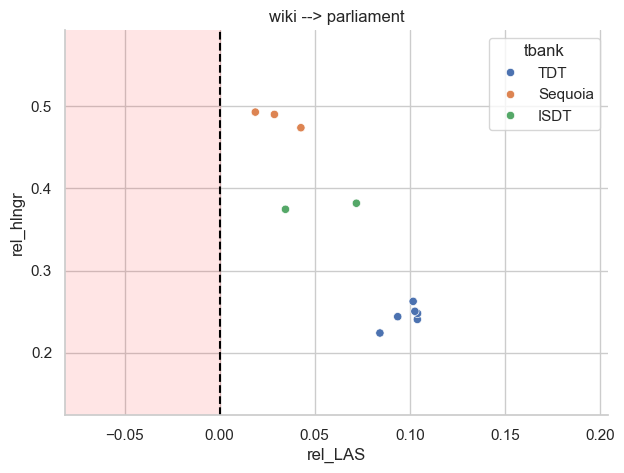

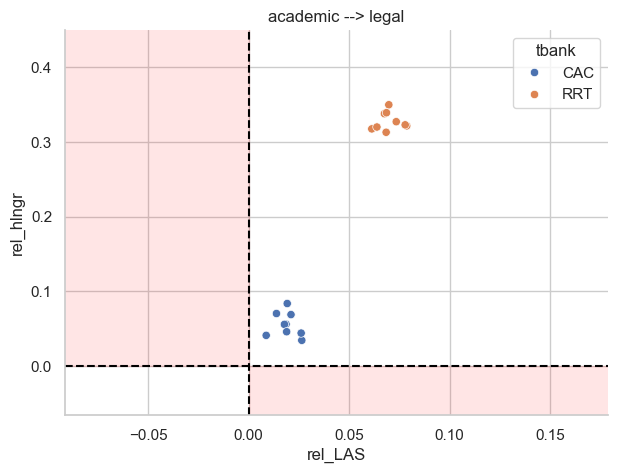

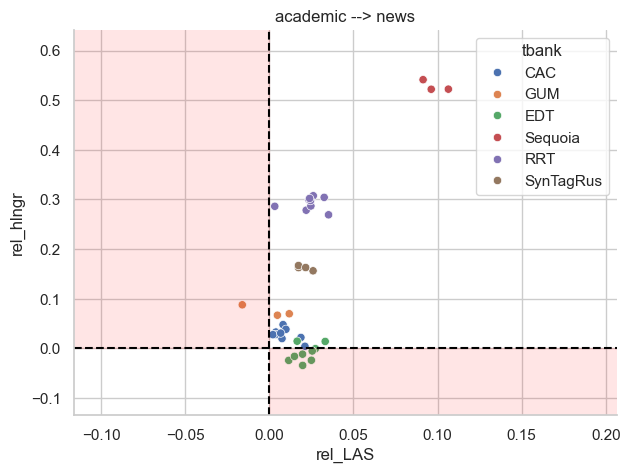

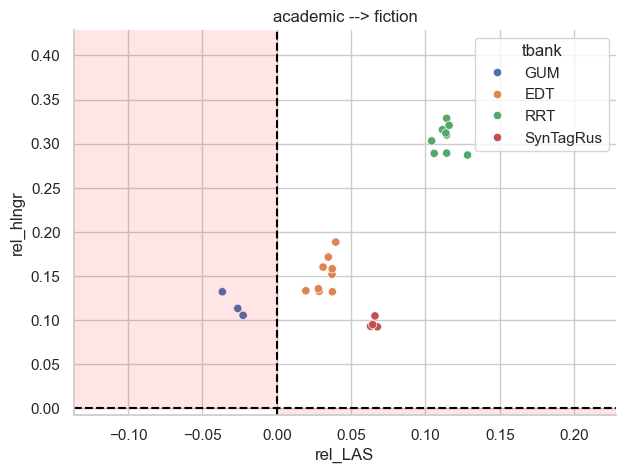

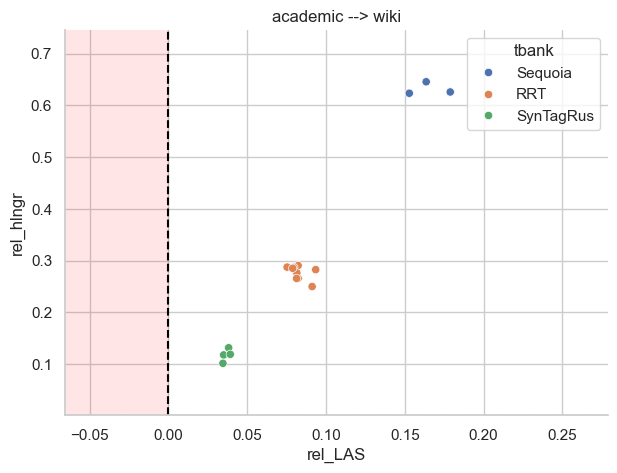

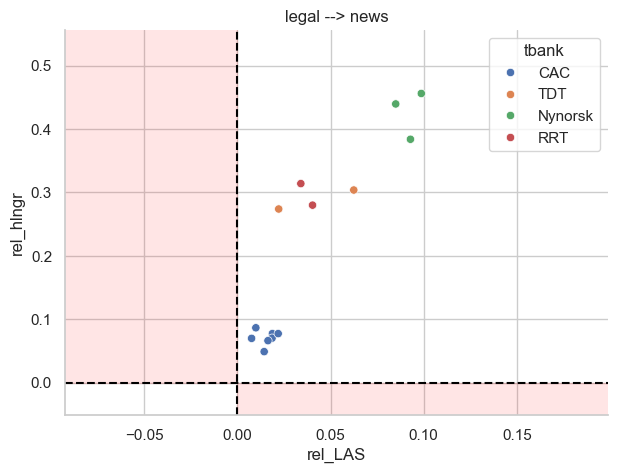

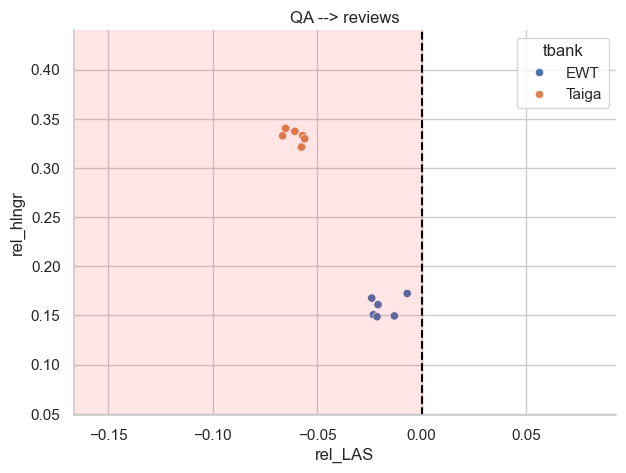

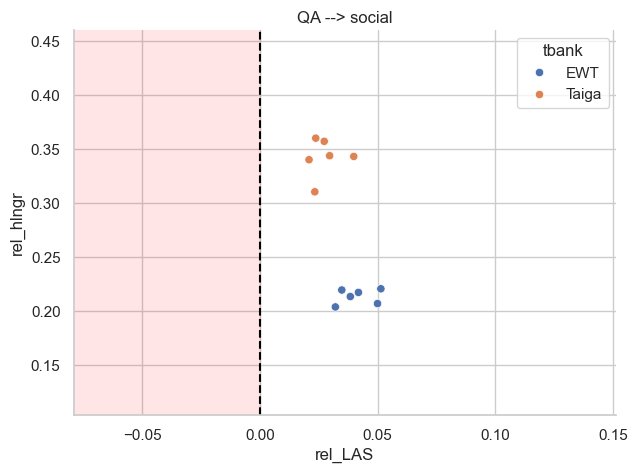

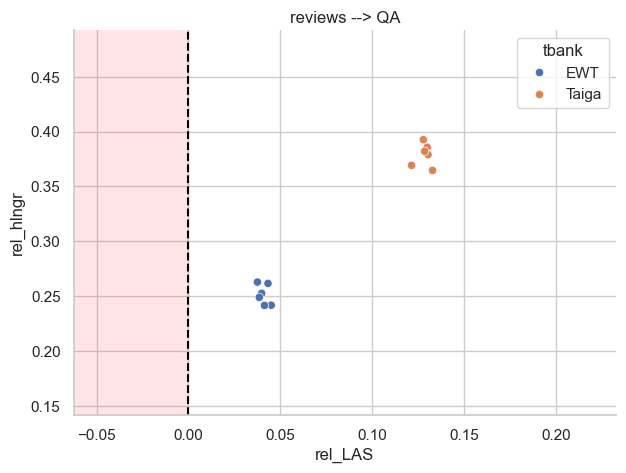

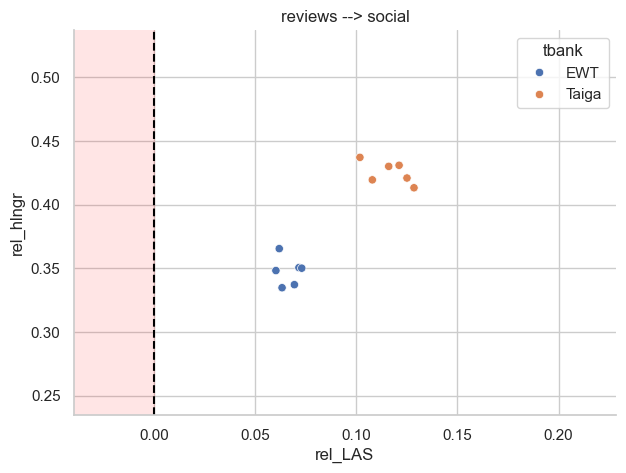

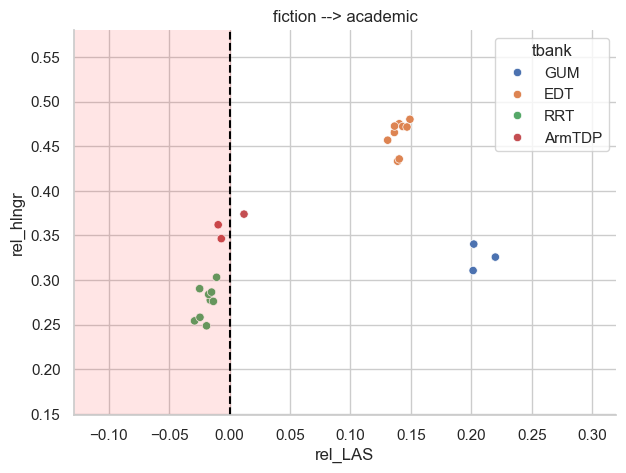

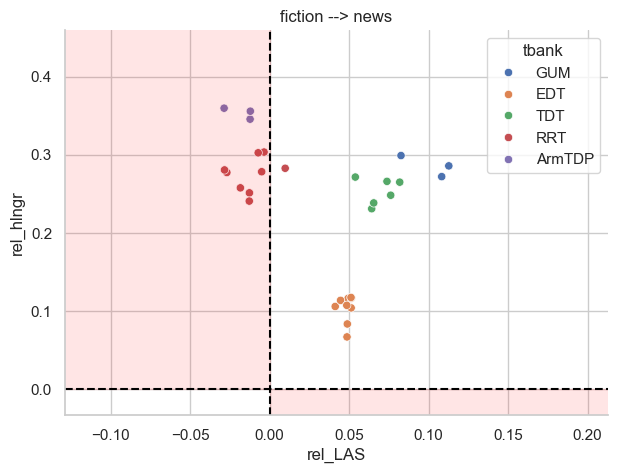

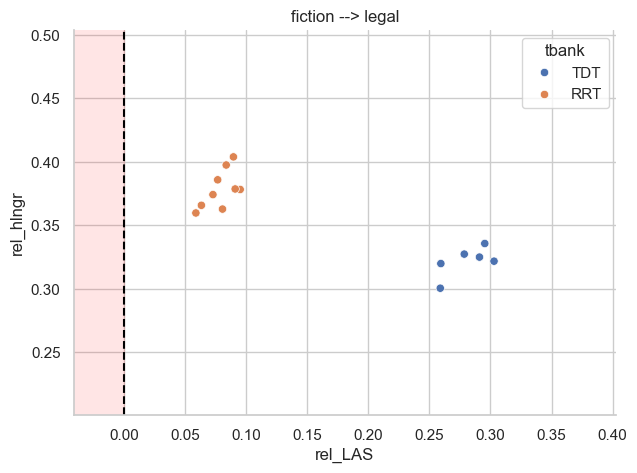

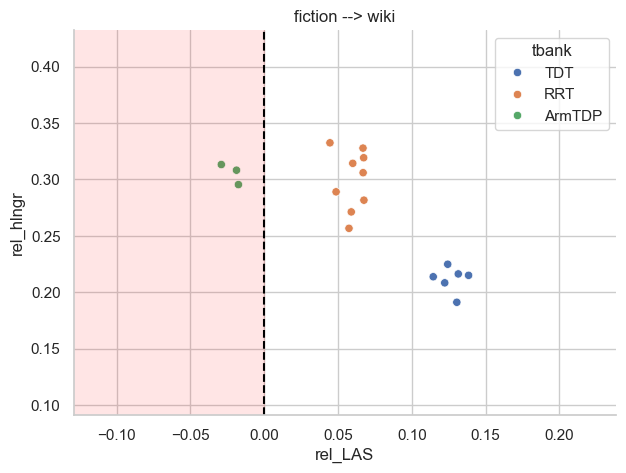

In [58]:
dist = 'rel_hlngr'

for sg in regplot_df.source_genre.unique():
    for tg in regplot_df[regplot_df.source_genre == sg].target_genre.unique():
        if (sg != tg)&(len(regplot_df[(regplot_df.source_genre == sg)&(regplot_df.target_genre == tg)]) >= 10):
            
            hue = 'tbank'
            plt.figure(figsize = (7,5))
            sns.set(style="whitegrid")
            data = regplot_df[(regplot_df.source_genre == sg)&(regplot_df.target_genre == tg)]
            g = sns.scatterplot(x='rel_LAS', y=dist, data=data, hue=hue)
            
            
            plt.axvline(0, c='black', ls='--') 
            plt.axhline(0, c='black', ls='--') 
            plt.fill_between((0,-10),(0,0), (10, 10), color = 'red', alpha = 0.1)
            plt.fill_between((0,10),(0,0), (-10, -10), color = 'red', alpha = 0.1)
            plt.ylim(data.rel_hlngr.min()-0.1,data.rel_hlngr.max()+0.1)
            plt.xlim(data.rel_LAS.min()-0.1,data.rel_LAS.max()+0.1)
            
                   
            plt.title(f'{sg} --> {tg}')
            sns.despine()
            # plt.savefig(f'{dist}_rel_LAS_{sg}-->{tg}_{hue}.png',dpi=300, bbox_inches = "tight")
            plt.show()

## correlation tables (Spearman, Kendall with permutation tests)

### within treebanks (absolute values)

In [78]:
corr_data = []

#absolute values, relationship within each tbank
regplot_df_abs = pd.DataFrame(plot_data_ABS)
regplot_df_abs.columns = ['lang', 'tbank', 'source_genre', 'sample', 'seed', 'target_genre', 'absolute LAS', 'H']#'KL', 'hlngr', 'rel_KL', 'rel_hlngr']
regplot_df_abs['source-->target'] = regplot_df_abs.apply(lambda df: f'{df.source_genre}-->{df.target_genre}', axis = 1)

for treebank in regplot_df_abs.tbank.unique():
    
    # exclude cross-treebank transfer (Nynorsk --> Nynorsk-LIA, GUM --> GUMReddit)
    if treebank == 'Nynorsk':
        data = regplot_df_abs[(regplot_df_abs.tbank == treebank)&(regplot_df_abs.source_genre != 'spoken')&(regplot_df_abs.target_genre != 'spoken')]
    elif treebank == 'GUM':
        data = regplot_df_abs[(regplot_df_abs.tbank == treebank)&(regplot_df_abs.source_genre != 'social')&(regplot_df_abs.target_genre != 'social')]
    else:
        data = regplot_df_abs[regplot_df_abs.tbank == treebank]
        
    las = data['absolute LAS'].tolist()
    H = data['H'].tolist()
    
    
    dof = len(las)-2             
    
    # permutation tests due to data size 
    def statistic(x):  # explore all possible pairings by permuting `x`
        rs = stats.spearmanr(x, H).statistic
        transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
        return transformed

    ref = stats.permutation_test((las,), statistic, alternative='two-sided', permutation_type='pairings')
    
    corr_data.append((treebank, round(stats.spearmanr(las,H).statistic,2), round(stats.kendalltau(las, H).statistic, 2), ref.pvalue))

In [65]:
print(pd.DataFrame(corr_data, columns = ['treebank', 'Spearman', 'Kendall', 'Spearman p-value (permutation)']).to_latex())

\begin{tabular}{llrrr}
\toprule
{} &   treebank &  Spearman &  Kendall &  Spearman p-value (permutation) \\
\midrule
0  &        HSE &     -0.66 &    -0.47 &                          0.0002 \\
1  &        CAC &     -0.19 &    -0.13 &                          0.1158 \\
2  &        EWT &     -0.32 &    -0.22 &                          0.0004 \\
3  &        GUM &     -0.40 &    -0.28 &                          0.0002 \\
4  &        EDT &     -0.50 &    -0.35 &                          0.0002 \\
5  &        TDT &     -0.67 &    -0.48 &                          0.0002 \\
6  &    Sequoia &     -0.82 &    -0.63 &                          0.0002 \\
7  &       ISDT &     -0.38 &    -0.26 &                          0.0022 \\
8  &    Nynorsk &     -0.47 &    -0.33 &                          0.0006 \\
9  &        RRT &     -0.48 &    -0.33 &                          0.0002 \\
10 &  SynTagRus &     -0.20 &    -0.13 &                          0.1746 \\
11 &      Taiga &     -0.56 &    -0.36 &       

/var/folders/td/pppt3n7d4dd4qwkwhqwbzwpw0000gn/T/ipykernel_62277/1582592388.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(corr_data, columns = ['treebank', 'Spearman', 'Kendall', 'Spearman p-value (permutation)']).to_latex())


### Spearman correlation in genre pairs
- filter by genre pairs present in no less than 4 treebanks

In [67]:
filt_tbs = []
regplot_df_filt=pd.DataFrame()
regplot_df_filt = regplot_df.query("tbank not in @filt_tbs")

regplot_df_lists = pd.DataFrame()
rel_LAS_lists = regplot_df_filt.groupby(['source_genre', 'target_genre'])['rel_LAS'].apply(list).values.tolist()
regplot_df_lists = regplot_df_filt.groupby(['source_genre', 'target_genre'])['rel_hlngr'].apply(list).reset_index()
regplot_df_lists['rel_LAS'] = rel_LAS_lists

In [83]:
corr_data_gpairs = []

def measure_corr_gpairs(df):
    
    global regplot_df_filt
    if len(df['rel_LAS']) > 10: #over 10 pairs
        
        source_genre = df['source_genre']
        target_genre = df['target_genre']
        rel_LAS = df['rel_LAS']
        rel_hlngr = df['rel_hlngr']
        lencor = len(regplot_df_filt[(regplot_df_filt.source_genre == source_genre)&(regplot_df_filt.target_genre == target_genre)].tbank.unique())
        if lencor >= 4:

            dof = len(rel_LAS)-2 

            def statistic(x):  # explore all possible pairings by permuting `x`
                rs = stats.spearmanr(x, rel_hlngr).statistic  # ignore pvalue
                transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
                return transformed

            ref = stats.permutation_test((rel_LAS,), statistic, alternative='two-sided', permutation_type='pairings')

            spcor = f"{stats.spearmanr(rel_LAS, rel_hlngr)[0]:.2}"
            
            #H0 - rel_LAS and rel_hlngr are independent
            if ref.pvalue <= 0.05:

                corr_data_gpairs.append((source_genre, target_genre, spcor, ref.pvalue))
                


regplot_df_lists.apply(lambda df: measure_corr_gpairs(df), axis = 1)

0      None
1      None
2      None
3      None
4      None
       ... 
128    None
129    None
130    None
131    None
132    None
Length: 133, dtype: object

In [84]:
print(pd.DataFrame(corr_data_gpairs, columns = ['source genre', 'target genre', 'Spearman', 'Spearman p-value (permutation)']).to_latex())

\begin{tabular}{llllr}
\toprule
{} & source genre &      target genre & Spearman &  Spearman p-value (permutation) \\
\midrule
0 &     academic &           fiction &     0.63 &                          0.0026 \\
1 &     academic &              news &     0.37 &                          0.0234 \\
2 &      fiction &          academic &     0.71 &                          0.0002 \\
3 &        legal &              news &     0.89 &                          0.0002 \\
4 &         news &          academic &    -0.45 &                          0.0088 \\
5 &         news &           fiction &    -0.45 &                          0.0094 \\
6 &         news &  nonfiction\_prose &      0.9 &                          0.0002 \\
\bottomrule
\end{tabular}



/var/folders/td/pppt3n7d4dd4qwkwhqwbzwpw0000gn/T/ipykernel_62277/3689349701.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(corr_data_gpairs, columns = ['source genre', 'target genre', 'Spearman', 'Spearman p-value (permutation)']).to_latex())
